# Emigration rates

At a high level:
- Use not-very-granular NIM estimates to work out emigration without many of the required stratifications.
- For the remaining stratifications, assume **emigrants** are like **immigrants.**

We do all operations at the **person** level, since that is the unit we have NIM estimates in.
Our final rate for household moves is therefore a rate of how many *people* should emigrate in
household moves.
In the simulation, we will sample households to emigrate until we hit our target # of people.

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
from numpy.random import default_rng
import scipy.stats as stats

pd.set_option('display.min_rows', 20)

! whoami
! date

zmbc
Thu Oct 13 23:25:43 PDT 2022


In [2]:
acs = pd.read_hdf('../data/acs_2020_5yr_person.hdf', key='acs')

In [3]:
# Duplicate indices! In the future, should probably deal with this in download_acs!
# Filter to relevant columns to save memory
acs = acs[['SERIALNO', 'MIG', 'RELSHIPP', 'HISP', 'RAC1P', 'AGEP', 'SEX', 'NATIVITY', 'ST', 'PUMA', 'PWGTP']].reset_index(drop=True)

In [4]:
len(acs[['ST', 'PUMA']].drop_duplicates())

2351

## Do subtraction of immigration - NIM to get total number of emigrants in each broad race group

NIM estimates are not fully stratified. They are available stratified only by county, and stratified only by (broad categories) of race/ethnicity.
We've decided to use the latter, since it will have more interesting PRL implications.

In [5]:
acs['immigrant'] = (acs.MIG == 2).astype(int)
acs['gq_person'] = acs.RELSHIPP.isin([37, 38]).astype(int)
acs['ref_person'] = (acs.RELSHIPP == 20).astype(int)
acs['immigrant_ref_person'] = ((acs.ref_person == 1) & (acs.immigrant == 1)).astype(int)

In [6]:
acs['hispanic'] = (acs.HISP != 1).astype(int)
acs['white_alone'] = (acs.RAC1P == 1).astype(int)
acs['three_category_race_eth'] = np.where(acs.hispanic == 1, 'hispanic', np.where(acs.white_alone == 1, 'white_alone_not_hispanic', 'other'))

In [7]:
# Data source: https://www.census.gov/data/tables/time-series/demo/popest/2020s-national-detail.html
# Download from: https://www2.census.gov/programs-surveys/popest/tables/2020-2021/national/asrh/nc-est2021-compn.xlsx
# Values extracted for annual (1-year, same as the ACS immigration question) change: total, Hispanic, non-Hispanic White alone. The "other" category should = total - Hispanic - non-Hispanic White alone.
nim = pd.DataFrame([
    {'three_category_race_eth': 'hispanic', 'nim': 82_225},
    {'three_category_race_eth': 'white_alone_not_hispanic', 'nim': 27_734},
    {'three_category_race_eth': 'other', 'nim': 244_622 - 82_225 - 27_734},
])
nim

,three_category_race_eth,nim
0,hispanic,82225
1,white_alone_not_hispanic,27734
2,other,134663


In [8]:
immigration_by_race_eth = acs[acs.immigrant == 1].groupby('three_category_race_eth').PWGTP.sum().rename('immigration')

In [9]:
emigration_by_race_eth = immigration_by_race_eth.reset_index().merge(nim, on='three_category_race_eth').assign(emigration=lambda x: x.immigration - x.nim).set_index('three_category_race_eth')
emigration_by_race_eth

,immigration,nim,emigration
three_category_race_eth,,,
hispanic,467697,82225,385472
other,755459,134663,620796
white_alone_not_hispanic,619679,27734,591945


## Split that into a count by move type, according to the proportions of ACS immigrants in each category

In [10]:
acs['move_type'] = np.where(acs.immigrant == 1, np.where(acs.gq_person == 1, 'gq person', np.where(acs.SERIALNO.isin(acs[acs.immigrant_ref_person == 1].SERIALNO), 'household', 'non-reference person')), 'none')

In [11]:
type_proportions_by_race_eth = (acs[acs.immigrant == 1].groupby(['three_category_race_eth', 'move_type']).PWGTP.sum() / acs[acs.immigrant == 1].groupby(['three_category_race_eth']).PWGTP.sum())
emigration_by_race_eth_type = emigration_by_race_eth.emigration * type_proportions_by_race_eth
emigration_by_race_eth_type

three_category_race_eth   move_type           
hispanic                  gq person                26577.710749
                          household               167618.344903
                          non-reference person    191275.944349
other                     gq person                46484.571801
                          household               307961.109927
                          non-reference person    266350.318273
white_alone_not_hispanic  gq person                34988.698116
                          household               374854.208493
                          non-reference person    182102.093390
dtype: float64

## Prepare to distribute counts by additional demographics

In order to do this, we need to add simulation demographics columns to ACS.

In [12]:
# Based on code from vivarium_census_prl_synth_pop repository:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L105-L118

LATINO_VAR_MAP = {i: (1 if i == 1 else 0) for i in range(1, 25)}

RACE_ETHNICITY_VAR_MAP = {
    0: "Latino",
    1: "White",
    2: "Black",
    3: "AIAN",
    4: "AIAN",
    5: "AIAN",
    6: "Asian",
    7: "NHOPI",
    8: "Multiracial or Other",
    9: "Multiracial or Other",
}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L99-L106

acs["race_ethnicity"] = acs.HISP.map(LATINO_VAR_MAP)
acs.loc[acs.race_ethnicity == 1, "race_ethnicity"] = acs.loc[
    acs.race_ethnicity == 1
].RAC1P

# label each race/eth
acs.race_ethnicity = acs.race_ethnicity.map(RACE_ETHNICITY_VAR_MAP)

In [13]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L120

SEX_VAR_MAP = {1: "Male", 2: "Female"}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L109

acs['sex'] = acs.SEX.map(SEX_VAR_MAP)

In [14]:
acs['born_in_us'] = acs.NATIVITY.map({1: 1, 2: 0})

In [15]:
acs['age_group'] = pd.cut(acs.AGEP, [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)

In [16]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/6b89c9243035592d595a142390b83dedb567896b/src/vivarium_census_prl_synth_pop/utilities.py#L196-L216
# with modifications
def vectorized_choice(
    options,
    n_to_choose: int,
    rng,
    weights = None,
    additional_key = None,
):
    if weights is None:
        n = len(options)
        weights = np.ones(n) / n
    # for each of n_to_choose, sample uniformly between 0 and 1
    probs = rng.random(n_to_choose)

    # build cdf based on weights
    pmf = weights / weights.sum()
    cdf = np.cumsum(pmf)

    # for each p_i in probs, count how many elements of cdf for which p_i >= cdf_i
    # slow way
    # vect_find_index = np.vectorize(lambda p_i: (p_i >= cdf).sum())
    # chosen_indices = vect_find_index(probs)
    # fast way
    chosen_indices = np.searchsorted(cdf, probs, side='right')
    return np.take(options, chosen_indices)

In [17]:
def perturb_with_unconditional(df, acs_subset, acs_full, rng, columns, subset_prob=0.4, all_prob=0.1):
    perturb_propensity = pd.Series(rng.random(len(df)), index=df.index)
    subset_cutoff = (1 - all_prob - subset_prob)
    assert subset_cutoff >= 0
    all_cutoff = (1 - all_prob)

    subset_perturb_indices = df.index[(perturb_propensity > subset_cutoff) & (perturb_propensity <= all_cutoff)]
    donors_subset = acs_subset.loc[vectorized_choice(acs_subset.index, len(subset_perturb_indices), rng, weights=acs_subset.PWGTP), columns]
    donors_subset.index = subset_perturb_indices
    
    all_perturb_indices = df.index[perturb_propensity > all_cutoff]
    donors_all = acs_full.loc[vectorized_choice(acs_full.index, len(all_perturb_indices), rng, weights=acs_full.PWGTP), columns]
    donors_all.index = all_perturb_indices

    df.loc[subset_perturb_indices, columns] = donors_subset[columns]
    df.loc[all_perturb_indices, columns] = donors_all[columns]
    return df

In [18]:
def sample_with_perturbation(acs_df, full_acs, rng, n, perturb_col_suffix=''):
    # NOTE: Unlike in the simulation, we only ever sample with the sampling unit being a person.
    sample = acs_df.loc[vectorized_choice(acs_df.index, n, rng, weights=acs_df.PWGTP)].reset_index(drop=True)

    sample = perturb_with_unconditional(sample, acs_df, full_acs, rng, ['ST' + perturb_col_suffix, 'PUMA' + perturb_col_suffix])
    # We don't perturb race because it is unclear how to do this at the household level.
    # sample = perturb_with_unconditional(sample, acs_df, full_acs, rng, ['three_category_race_eth' + perturb_col_suffix, 'race_ethnicity' + perturb_col_suffix], subset_prob=0.2, all_prob=0.1)

    age_col = 'AGEP' + perturb_col_suffix
    lower_bound = np.where((sample.gq_person == 1) & (sample[age_col] >= 18), -1 * (sample[age_col] - 18), -1 * sample[age_col])
    mean = 0
    std = 10
    age_shift = stats.truncnorm(a=((lower_bound - mean) / std), b=np.inf, loc=mean, scale=std).rvs(random_state=rng)

    sample[age_col] += age_shift
    sample[age_col] = np.clip(sample[age_col], -np.inf, 125)
    
    sample['age_group' + perturb_col_suffix] = pd.cut(sample[age_col], [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)
    
    return sample

In [19]:
def sample_acs_move_type(acs_df, move_type, rng_seed=12345, n=50_000_000, perturb_col_suffix=''):
    acs_subset = acs_df[(acs_df.immigrant == 1) & (acs_df.move_type == move_type)]
    return sample_with_perturbation(acs_subset, acs_df, default_rng(rng_seed), n=n, perturb_col_suffix=perturb_col_suffix)

In [20]:
def sample_acs_at_risk(acs_df, move_type, rng_seed=12345, n=50_000_000, perturb_col_suffix=''):
    at_risk = acs_df[(acs_df.gq_person == (move_type == 'gq person'))]
    return sample_with_perturbation(acs_df, acs_df, default_rng(rng_seed), n=n, perturb_col_suffix=perturb_col_suffix)

In [21]:
def distribute_by_immigration_and_calculate_rate(emigration, distribute_by, acs_df, move_type, at_risk, stratification_columns=['three_category_race_eth', 'age_group', 'sex', 'race_ethnicity', 'born_in_us'], col_suffix=''):
    emigration_to_distribute = emigration[emigration.index.get_level_values('move_type') == move_type]

    distribution_proportions = distribute_by.groupby([col + col_suffix for col in stratification_columns]).size() / len(distribute_by)
    distribution_proportions.index.names = stratification_columns

    emigration_stratified_count = emigration_to_distribute * distribution_proportions
    assert np.all(emigration_stratified_count[emigration_stratified_count > 0].reset_index().groupby([c for c in stratification_columns if c != 'three_category_race_eth']).size() <= 1)
    emigration_stratified_count = emigration_stratified_count.rename('emigration').reset_index().groupby([c for c in stratification_columns if c != 'three_category_race_eth']).emigration.sum()

    denominators = acs_df[(acs_df.gq_person == (move_type == 'gq person'))].PWGTP.sum() * (at_risk.groupby([c for c in stratification_columns if c != 'three_category_race_eth']).size() / len(at_risk))

    return emigration_stratified_count, (emigration_stratified_count / denominators).rename('emigration_rate')

## Non-reference-person emigration rate

- With the count of non-reference-person emigrants:
  - Distribute that count of non-reference-person emigrants using age/sex/race/birthplace/PUMA? proportions among non-reference-person immigrants in ACS.
  - Divide each sub-count by the people in that age/sex/race/birthplace/PUMA? group in ACS to get the rate.
  - Sample individuals for emigration at that rate.

In [22]:
def display_sample_size(acs_df, move_type, stratification_columns=['age_group', 'sex', 'race_ethnicity', 'born_in_us'], col_suffix=''):
    acs_subset = acs_df[(acs_df.immigrant == 1) & (acs_df.move_type == move_type)]
    sample_size = acs_subset.groupby([col + col_suffix for col in stratification_columns]).size().rename('sample_size').reset_index()
    sample_size[['age_start', 'age_end']] = [[x.left, x.right] for x in sample_size['age_group' + col_suffix]]
    sample_size['age'] = np.average(sample_size[['age_start', 'age_end']], axis=1)

    g = sns.relplot(
        data=sample_size,
        x="age", y="sample_size",
        hue="race_ethnicity" + col_suffix,
        row="born_in_us" + col_suffix, col="sex" + col_suffix,
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )
    g.set(yscale="symlog")
    g.set(ylim=(0, None))
    return g

In [23]:
def display_emigration_rates(emigration_rates, name):
    emigration_rates = emigration_rates.rename(name).reset_index()
    emigration_rates[['age_start', 'age_end']] = [[x.left, x.right] for x in emigration_rates['age_group']]
    emigration_rates['age'] = np.average(emigration_rates[['age_start', 'age_end']], axis=1)
    
    sns.relplot(
        data=emigration_rates,
        x="age", y=name,
        hue="race_ethnicity",
        row="born_in_us", col="sex",
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )

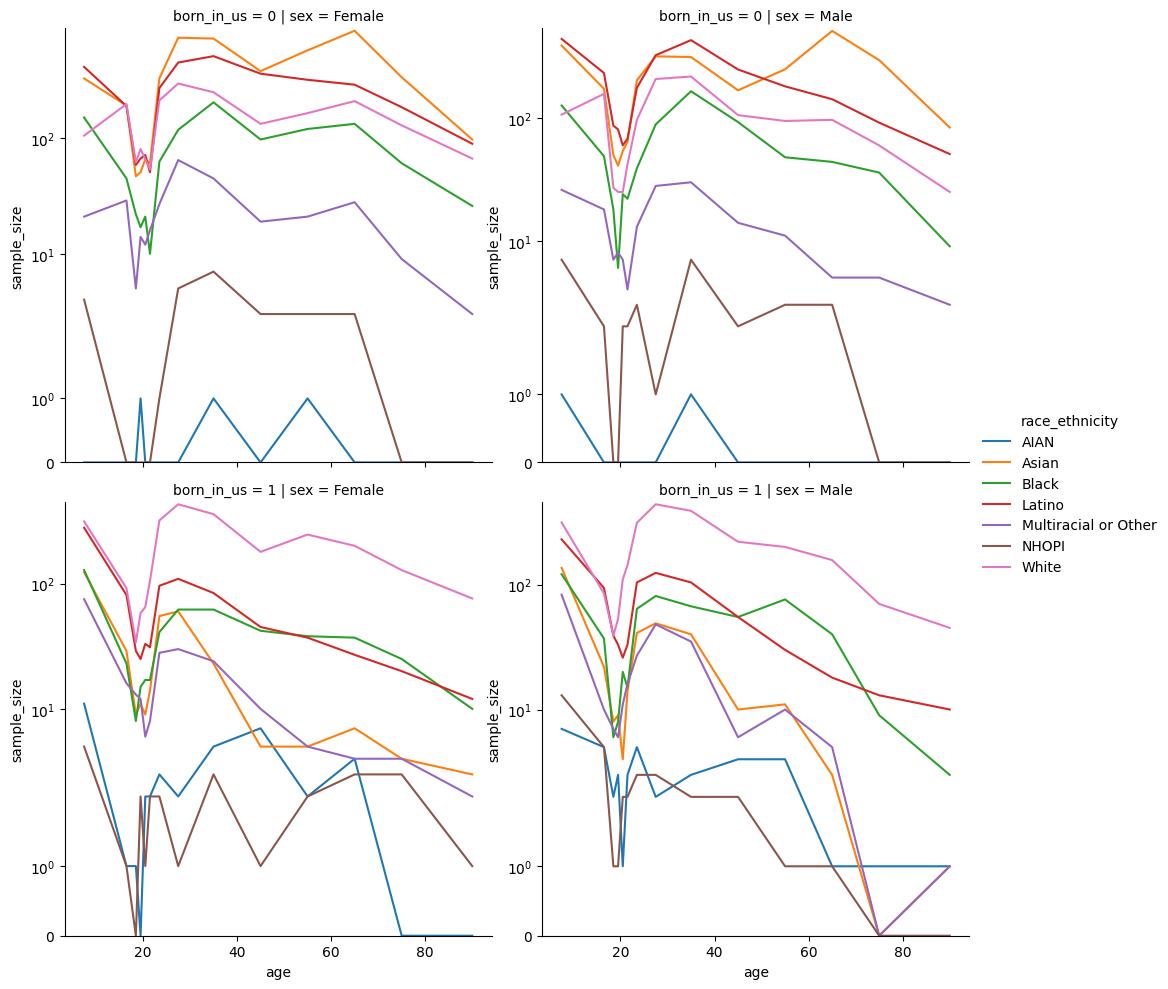

In [24]:
display_sample_size(acs, 'non-reference person')

In [25]:
%%time

distribute_by = sample_acs_move_type(acs, 'non-reference person')

CPU times: user 1h 21min 57s, sys: 3min 18s, total: 1h 25min 15s
Wall time: 1h 21min 26s


In [26]:
%%time

at_risk = sample_acs_at_risk(acs, 'non-reference person')

CPU times: user 1h 22min 52s, sys: 2min 59s, total: 1h 25min 52s
Wall time: 1h 22min 33s


In [27]:
%%time

nrp_emigration_counts, nrp_emigration_rates = distribute_by_immigration_and_calculate_rate(emigration_by_race_eth_type, distribute_by, acs, 'non-reference person', at_risk)

CPU times: user 24.5 s, sys: 7.02 s, total: 31.5 s
Wall time: 31.5 s


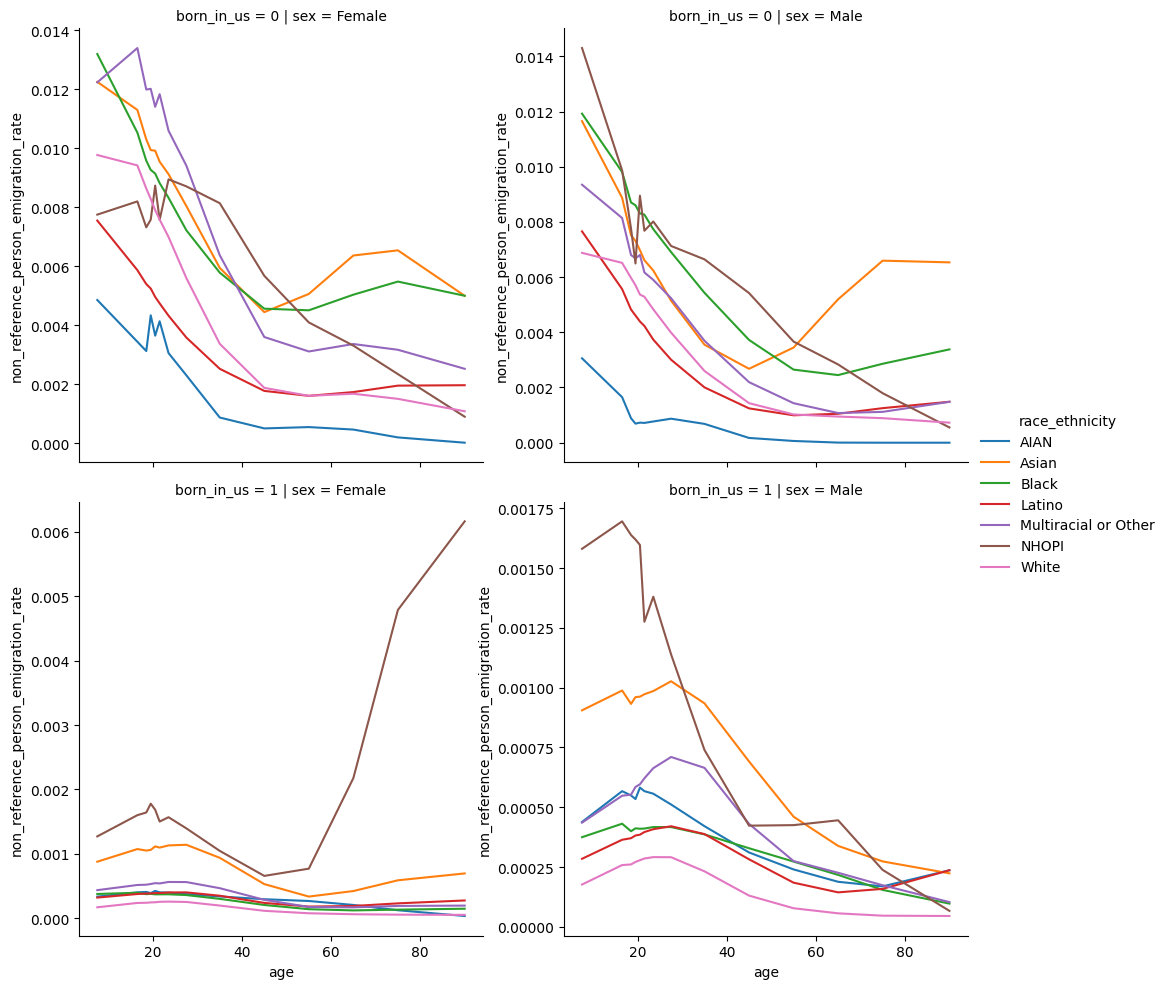

In [28]:
display_emigration_rates(nrp_emigration_rates, 'non_reference_person_emigration_rate')

In [29]:
%%time

nrp_emigration_counts_by_state, nrp_emigration_rates_by_state = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs,
    'non-reference person',
    at_risk,
    stratification_columns=['three_category_race_eth', 'age_group', 'sex', 'race_ethnicity', 'born_in_us', 'ST']
)

CPU times: user 27 s, sys: 8.22 s, total: 35.2 s
Wall time: 35.2 s


In [30]:
nrp_emigration_rates_by_state

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1     0.001045
                                               2     0.002230
                                               4     0.000697
                                               5     0.000836
                                               6     0.022460
                                               8          inf
                                               9     0.005018
                                               10         inf
                                               11         inf
                                               12    0.002585
                                                       ...   
[80, 100)  Male    White           1           46    0.000056
                                               47    0.000039
                                               48    0.000052
                                               49    0.000059
                    

In [31]:
nrp_emigration_rates_by_state.sort_values()

age_group  sex   race_ethnicity        born_in_us  ST
[60, 70)   Male  AIAN                  0           33    0.0
[70, 80)   Male  AIAN                  0           31    0.0
                                                   29    0.0
                                                   28    0.0
                                                   26    0.0
[50, 60)   Male  AIAN                  0           19    0.0
                                                   20    0.0
[80, 100)  Male  Multiracial or Other  1           23    0.0
                 AIAN                  1           16    0.0
[50, 60)   Male  AIAN                  0           21    0.0
                                                        ... 
[80, 100)  Male  NHOPI                 0           10    NaN
                                                   16    NaN
                                                   30    NaN
                                                   33    NaN
                               

In [32]:
len(nrp_emigration_rates_by_state[nrp_emigration_rates_by_state.isnull()])

504

In [33]:
len(nrp_emigration_rates_by_state[nrp_emigration_rates_by_state == np.inf])

396

In [34]:
len(nrp_emigration_rates_by_state[nrp_emigration_rates_by_state == 0])

600

In [35]:
nrp_emigration_rates_by_state = nrp_emigration_rates_by_state.replace(np.inf, np.nan).fillna(nrp_emigration_rates_by_state.median())
nrp_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity  born_in_us  ST
[80, 100)  Male    AIAN            0           53    0.000000
[21, 22)   Female  AIAN            0           9     0.000000
[18, 19)   Male    NHOPI           1           30    0.000000
[70, 80)   Male    AIAN            0           4     0.000000
                                               6     0.000000
[50, 60)   Male    NHOPI           1           20    0.000000
[0, 15)    Male    AIAN            0           28    0.000000
[70, 80)   Male    AIAN            0           9     0.000000
[50, 60)   Female  NHOPI           1           56    0.000000
[70, 80)   Male    AIAN            0           12    0.000000
                                                       ...   
[80, 100)  Female  NHOPI           1           1     0.154353
[22, 25)   Female  NHOPI           0           45    0.161401
[30, 40)   Female  NHOPI           0           2     0.166956
[19, 20)   Female  NHOPI           0           2     0.170600
[21, 22)   Male    N

In [36]:
nrp_emigration_rates_by_state.to_csv('sim_inputs/non_reference_person_emigration_rates.csv')

## GQ person emigration rate

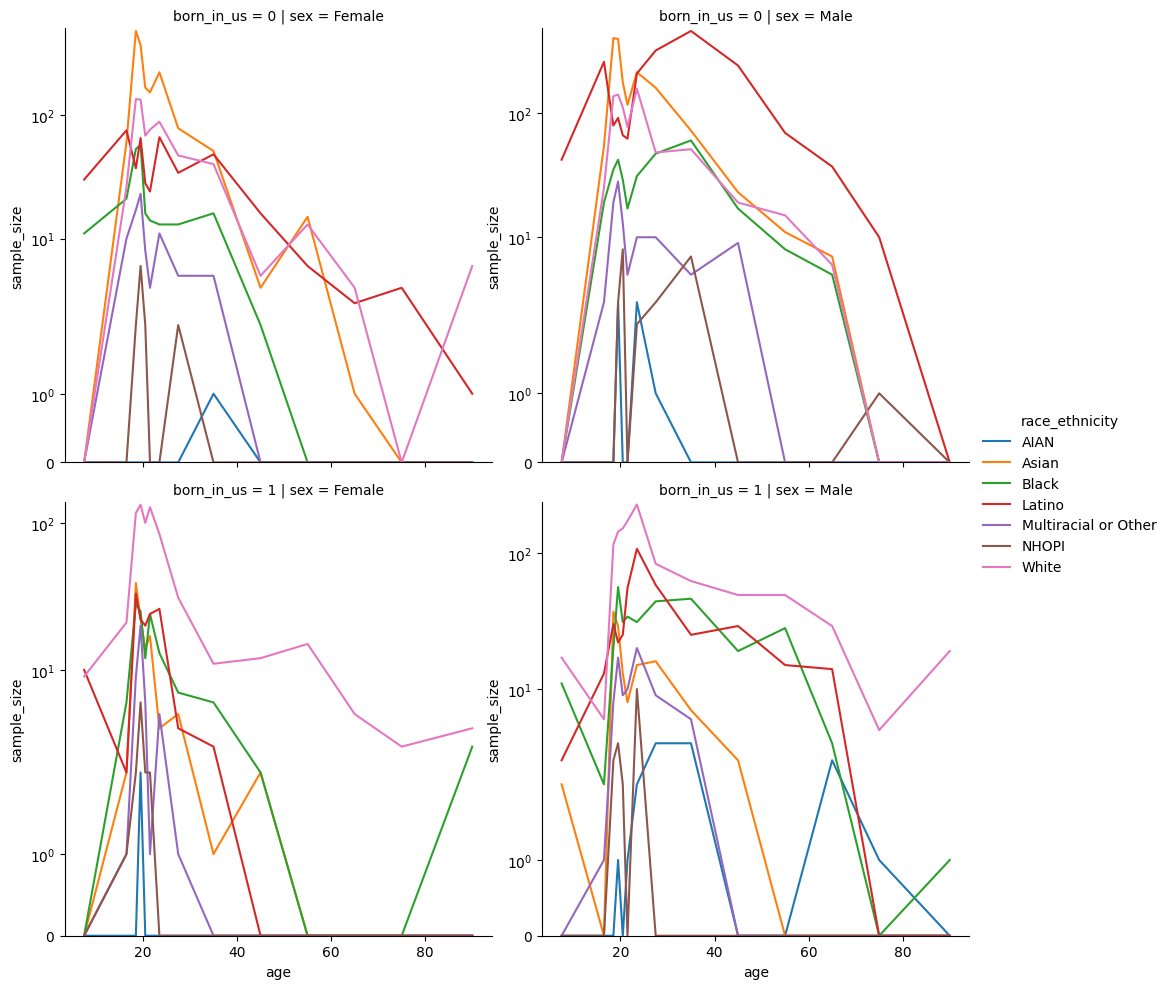

In [37]:
display_sample_size(acs, 'gq person')

In [38]:
%%time

distribute_by = sample_acs_move_type(acs, 'gq person')

CPU times: user 1h 21min 4s, sys: 3min 4s, total: 1h 24min 8s
Wall time: 1h 20min 48s


In [39]:
%%time

at_risk = sample_acs_at_risk(acs, 'gq person')

CPU times: user 1h 23min 12s, sys: 3min 9s, total: 1h 26min 22s
Wall time: 1h 22min 58s


In [40]:
%%time

gq_emigration_counts, gq_emigration_rates = distribute_by_immigration_and_calculate_rate(emigration_by_race_eth_type, distribute_by, acs, 'gq person', at_risk)

CPU times: user 21.4 s, sys: 6.27 s, total: 27.7 s
Wall time: 27.6 s


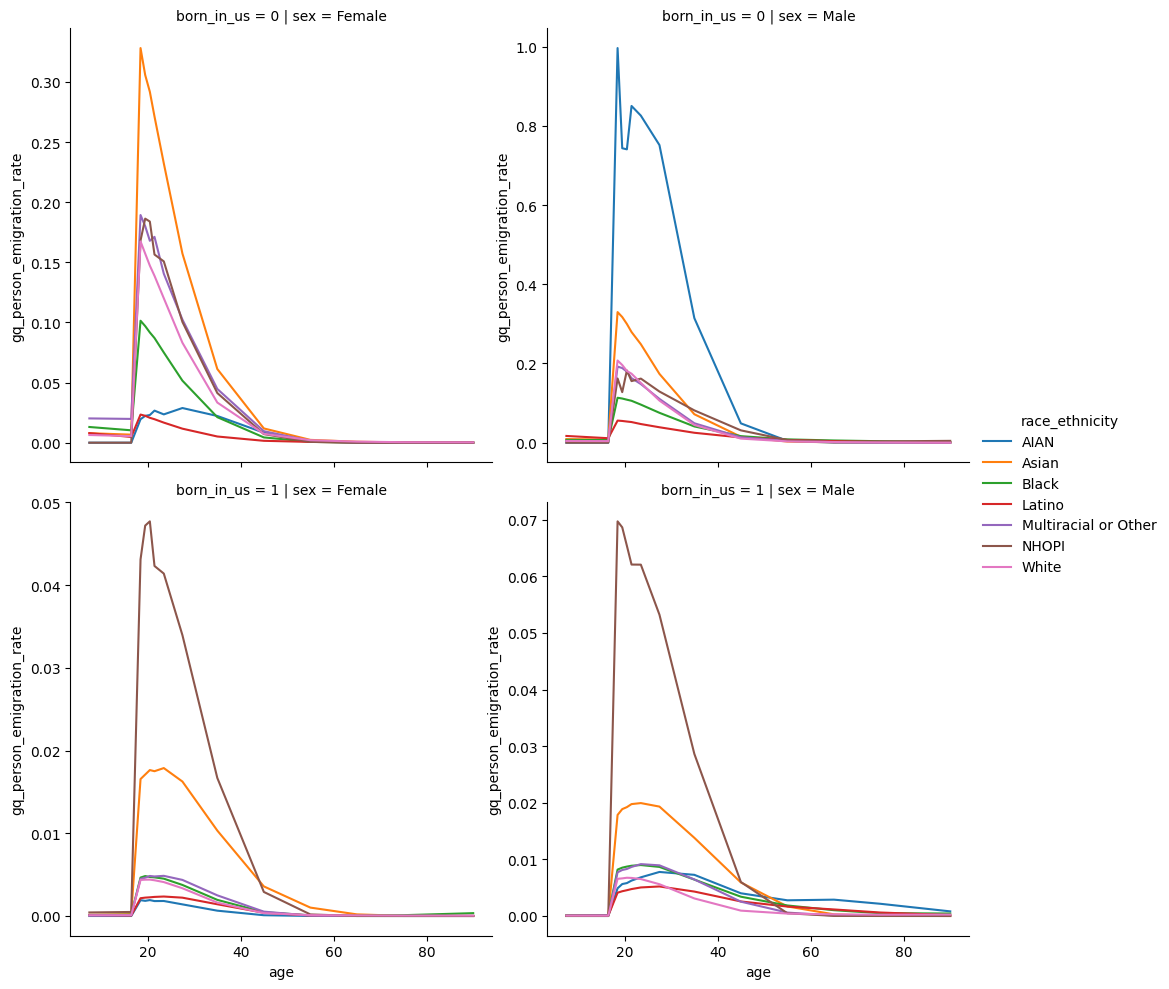

In [41]:
display_emigration_rates(gq_emigration_rates, 'gq_person_emigration_rate')

In [42]:
%%time

gq_emigration_counts_by_state, gq_emigration_rates_by_state = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs,
    'gq person',
    at_risk,
    stratification_columns=['three_category_race_eth', 'age_group', 'sex', 'race_ethnicity', 'born_in_us', 'ST']
)

CPU times: user 23.8 s, sys: 6.99 s, total: 30.8 s
Wall time: 30.8 s


In [43]:
gq_emigration_rates_by_state

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1     0.000000
                                               2     0.000000
                                               4     0.000000
                                               5     0.000000
                                               6     0.000000
                                               8          NaN
                                               9     0.000000
                                               10         NaN
                                               11         NaN
                                               12    0.000000
                                                       ...   
[80, 100)  Male    White           1           46    0.000072
                                               47    0.000084
                                               48    0.000231
                                               49    0.000242
                    

In [44]:
gq_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity        born_in_us  ST
[0, 15)    Female  AIAN                  0           1     0.0
[15, 18)   Male    Multiracial or Other  0           31    0.0
[70, 80)   Female  NHOPI                 0           33    0.0
                                                     32    0.0
                                                     31    0.0
                                                     29    0.0
                                                     28    0.0
                                                     27    0.0
                                                     26    0.0
                                                     25    0.0
                                                          ... 
[80, 100)  Male    AIAN                  0           56    NaN
                   Multiracial or Other  0           38    NaN
                                                     56    NaN
                   NHOPI                 0           5     NaN

In [45]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state.isnull()])

366

In [46]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state == np.inf])

534

In [47]:
len(gq_emigration_rates_by_state[gq_emigration_rates_by_state == 0])

2563

In [48]:
gq_emigration_rates_by_state = gq_emigration_rates_by_state.replace(np.inf, np.nan).fillna(gq_emigration_rates_by_state.median())
gq_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity        born_in_us  ST
[0, 15)    Female  AIAN                  0           1      0.000000
[70, 80)   Female  NHOPI                 0           29     0.000000
                                                     28     0.000000
                                                     27     0.000000
                                                     26     0.000000
                                                     25     0.000000
                                                     24     0.000000
[15, 18)   Male    Black                 1           10     0.000000
[70, 80)   Female  NHOPI                 0           23     0.000000
                                                     22     0.000000
                                                             ...    
[21, 22)   Female  Multiracial or Other  0           33     2.398120
[19, 20)   Female  Multiracial or Other  0           31     2.481608
[21, 22)   Male    NHOPI                 0     

In [49]:
gq_emigration_rates_by_state.to_csv('sim_inputs/group_quarters_person_emigration_rates.csv')

## Household emigration rate

- With the count of household emigrants:
  - Distribute that count of household emigrants using age/sex/race/birthplace/PUMA? proportions of household immigrants’ reference person in ACS.
  - Divide each sub-count by the people with a reference person with that age/sex/race/birthplace/PUMA? in ACS to get the person-level rate.
  - Multiply that rate by the current in-sim population size to get the desired count of emigrants, then sample households until you reach that desired count.

In [50]:
%%time

acs_with_reference_person_info = acs.merge(acs[acs.ref_person == 1][['SERIALNO', 'ST', 'PUMA', 'three_category_race_eth', 'AGEP', 'age_group', 'sex', 'race_ethnicity', 'born_in_us']], suffixes=('', '_ref_person'), on='SERIALNO')

CPU times: user 18.8 s, sys: 6.39 s, total: 25.2 s
Wall time: 25.2 s


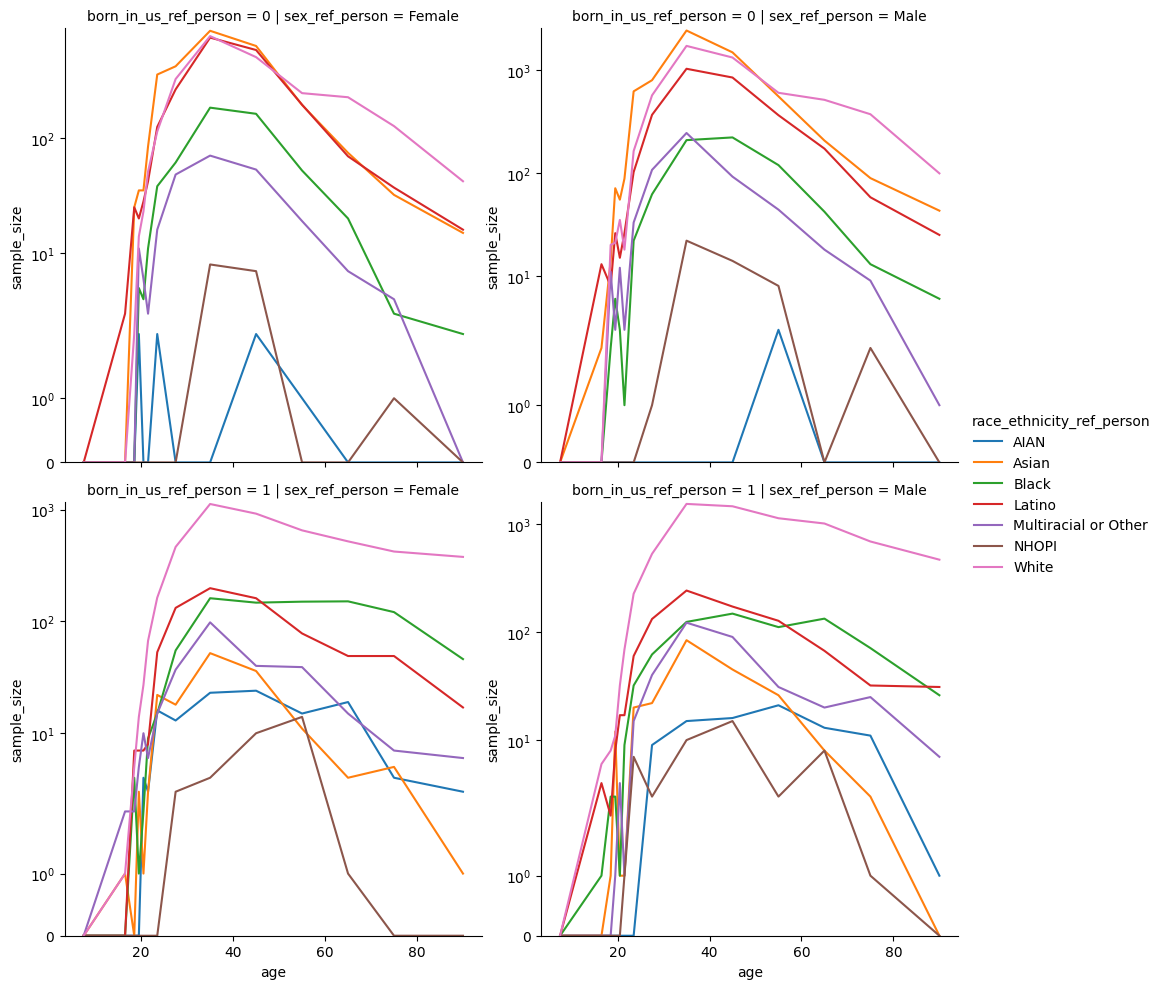

In [51]:
display_sample_size(acs_with_reference_person_info, 'household', col_suffix='_ref_person')

In [52]:
%%time

distribute_by = sample_acs_move_type(acs_with_reference_person_info, 'household', perturb_col_suffix='_ref_person')

CPU times: user 1h 21min 41s, sys: 3min 16s, total: 1h 24min 58s
Wall time: 1h 21min 23s


In [53]:
%%time

at_risk = sample_acs_at_risk(acs_with_reference_person_info, 'household', perturb_col_suffix='_ref_person')

CPU times: user 1h 23min 58s, sys: 3min 19s, total: 1h 27min 17s
Wall time: 1h 23min 48s


In [54]:
%%time

household_emigration_counts, household_emigration_rates = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs_with_reference_person_info,
    'household',
    at_risk,
    col_suffix='_ref_person'
)

CPU times: user 24.7 s, sys: 7.73 s, total: 32.4 s
Wall time: 32.4 s


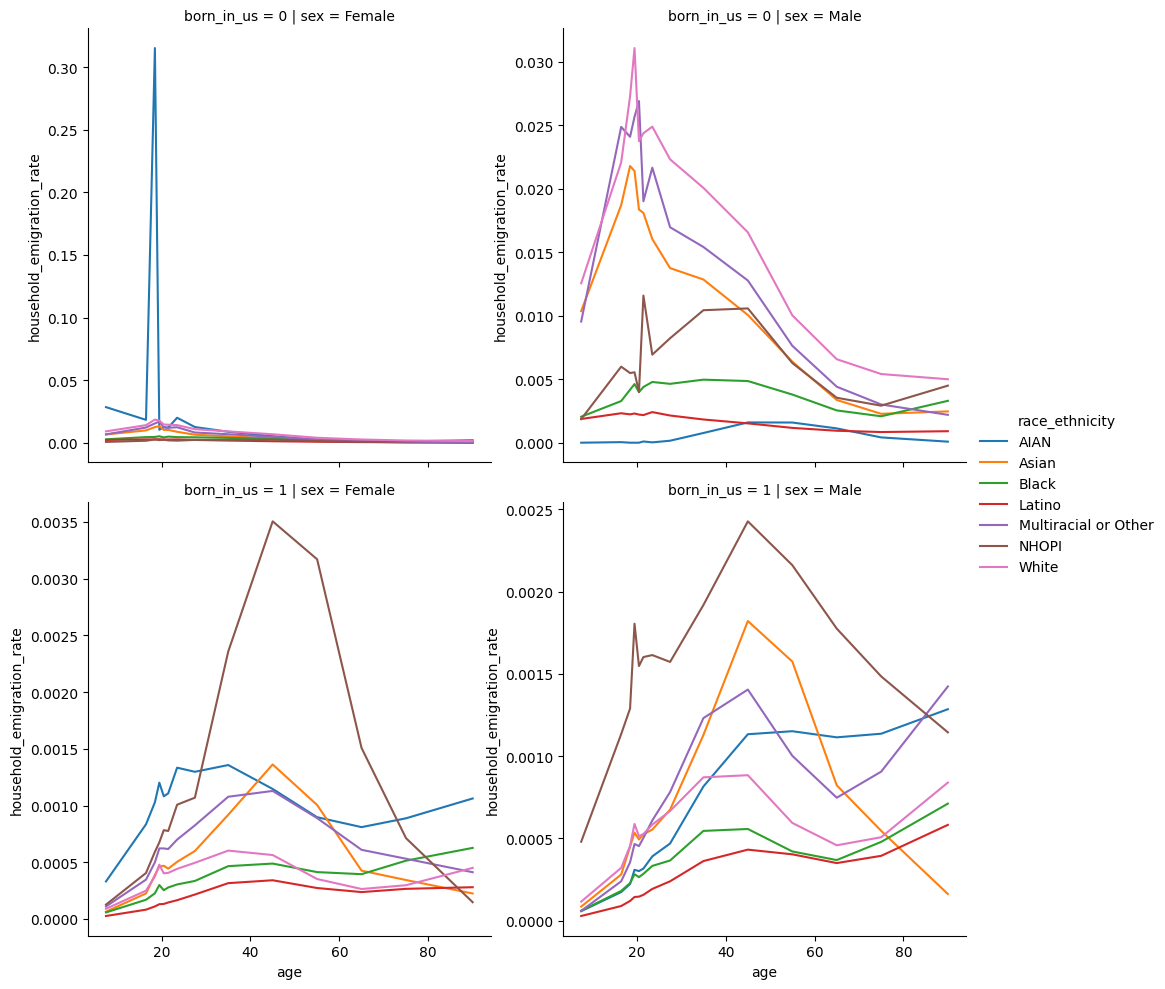

In [55]:
display_emigration_rates(household_emigration_rates, 'household_emigration_rate')

In [56]:
%%time

household_emigration_counts_by_state, household_emigration_rates_by_state = distribute_by_immigration_and_calculate_rate(
    emigration_by_race_eth_type,
    distribute_by,
    acs_with_reference_person_info,
    'household',
    at_risk,
    col_suffix='_ref_person',
    stratification_columns=['three_category_race_eth', 'age_group', 'sex', 'race_ethnicity', 'born_in_us', 'ST']
)

CPU times: user 28.1 s, sys: 8.59 s, total: 36.7 s
Wall time: 36.7 s


In [57]:
household_emigration_rates_by_state

age_group  sex     race_ethnicity  born_in_us  ST
[0, 15)    Female  AIAN            0           1          inf
                                               2          inf
                                               4     0.006768
                                               5          inf
                                               6     0.027847
                                               8          inf
                                               9          inf
                                               10         inf
                                               11         inf
                                               12    0.007438
                                                       ...   
[80, 100)  Male    White           1           46    0.000486
                                               47    0.000754
                                               48    0.001136
                                               49    0.001320
                    

In [58]:
household_emigration_rates_by_state.sort_values()

age_group  sex   race_ethnicity  born_in_us  ST
[18, 19)   Male  NHOPI           1           10    0.0
[0, 15)    Male  AIAN            0           36    0.0
[80, 100)  Male  AIAN            0           42    0.0
                                             39    0.0
[25, 30)   Male  AIAN            0           36    0.0
[80, 100)  Male  AIAN            0           34    0.0
                                             26    0.0
                                             13    0.0
[25, 30)   Male  AIAN            0           34    0.0
[80, 100)  Male  AIAN            0           12    0.0
                                                  ... 
                 NHOPI           0           38    NaN
                                             46    NaN
                                 1           2     NaN
                                             16    NaN
                                             30    NaN
                                             38    NaN
                 

In [59]:
len(household_emigration_rates_by_state[household_emigration_rates_by_state.isnull()])

872

In [60]:
len(household_emigration_rates_by_state[household_emigration_rates_by_state == np.inf])

2286

In [61]:
len(household_emigration_rates_by_state[household_emigration_rates_by_state == 0])

212

In [62]:
household_emigration_rates_by_state = household_emigration_rates_by_state.replace(np.inf, np.nan).fillna(household_emigration_rates_by_state.median())
household_emigration_rates_by_state.sort_values()

age_group  sex     race_ethnicity        born_in_us  ST
[60, 70)   Male    AIAN                  0           23    0.000000
[25, 30)   Female  NHOPI                 1           10    0.000000
[60, 70)   Male    AIAN                  0           19    0.000000
[22, 25)   Male    AIAN                  0           48    0.000000
                                                     42    0.000000
                                                     41    0.000000
                                                     39    0.000000
                                                     38    0.000000
                                                     36    0.000000
                                                     29    0.000000
                                                             ...   
[15, 18)   Male    Multiracial or Other  0           42    0.398372
[19, 20)   Male    White                 0           40    0.427233
[15, 18)   Male    White                 0           15    0

In [63]:
household_emigration_rates_by_state.to_csv('sim_inputs/household_emigration_rates.csv')